# makemore part 4: Becoming a Backprop Ninja

## What is makemore?

Makemore "makes more" of things that you give it. Example uses `names.txt` and makemore learns to make names

Under the hood, makemore is a character-level language model: it treats each line as sequences of individual characters. Model sequence of characters and try to predict next characters in a sequence.

This class will look at 
1. Bigram (one character simply predicts a next one with a lookup table of counts)
2. ~~Bag of Words~~
   1. The table explodes! We'll skip
3. **Multilayer Perceptron**
4. Recurrent Neural Network
5. GRU
6. Transformers

Will build a transformer equivalent to GPT-2, at the level of characters

## Agenda
Characters
Words
Images

## Backprop

In this lecture, we will manually work through backpropagation to see how it works and gain an intuitive undertanding of how gradients flow through the compute graph

### Why?

[Andrej wrote about this before](https://karpathy.medium.com/yes-you-should-understand-backprop-e2f06eab496b)

#### Trivia

Deep learning used to be done in Matlab!

---

## External Resources

### Lesson

[Building makemore Part 4: Becoming a Backprop Ninja (youtube)](https://www.youtube.com/watch?v=q8SA3rM6ckI)


___

## Import necessary libraries

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

---

In [2]:
# read in all the words
names_data = '../../data/raw/names.txt'

words = open(names_data, 'r').read().splitlines()

print(len(words))
print(max(len(w) for w in words))
print(words[:10])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']


In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i  in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
# build the dataset but via a function instead
block_size = 3 # context length: how many characters do we take to predict the next one?
    
def build_dataset(words):
    X, Y = [], []
    
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])        #80%
Xdev, Ydev = build_dataset(words[n1:n2])    #10%
Xte, Yte = build_dataset(words[n2:])        #10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [5]:
# utility function we will use later when comparing manual gradients to PyTorch gradients
def cmp(s, dt, t):
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt, t.grad)
    maxdiff = (dt - t.grad).abs().max().item()
    print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [6]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)

# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / ((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden, generator=g) * 0.1 # using b1 just for fun, it's useless because of the BatchNormalization layer

# Layer 2
W2 = torch.randn((n_hidden,vocab_size), generator=g) * 0.1
b2 = torch.randn(vocab_size, generator=g) * 0.1

# BatchNorm parameters
bngain = torch.ones((1, n_hidden)) * 0.1 + 1.0
bnbias = torch.zeros((1, n_hidden)) * 0.1

# Note: I am initializing many of these parameters in non-standard ways because sometimes initializing with e.g. all zeros could mask an incorrect implementation of the backward pass
# bnmean_running = torch.zeros((1, n_hidden))
# bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]

print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

12297


In [7]:
batch_size = 32
n = batch_size # a shorter variable also, for convenience

# construct a minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

In [8]:
# forward pass, "chunkated" into smaller steps that are possible to backward one at a time

emb = C[Xb] # embed the characters into vectors
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors

# Linear layer 1
hprebn = embcat @ W1 + b1 # hidden layer pre-activation

# BatchNorm layer 
bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0,keepdim=True) # note: Bessel's corection (dividing by n-1, not n)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias

# non-linearity
h = torch.tanh(hpreact) # hidden layer

# linear layer 2
logits = h @ W2 + b2 # output layer

# cross entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) isntead then I can't get backprop to be bit exact...
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# PyTorch backward pass
for p in parameters:
    p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, # afaik there is no cleaner way
          norm_logits, logit_maxes, logits, h, hpreact, bnraw, 
          bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani, 
          embcat, emb]:
    t.retain_grad()
loss.backward()
loss

tensor(3.8279, grad_fn=<NegBackward0>)

In [9]:
logprobs.shape

torch.Size([32, 27])

In [10]:
Yb

tensor([ 1, 12,  0,  5,  9, 18,  9, 16,  1,  0,  0,  1,  0,  0, 14, 12,  0,  0,
         0,  8, 25,  5,  0, 20, 19, 15, 12, 22, 22,  2, 21, 18])

In [11]:
logprobs

tensor([[-4.4737, -1.5997, -4.0965, -3.4163, -2.8133, -4.0841, -4.6294, -4.3522,
         -3.4315, -3.8062, -2.8183, -4.9644, -3.8716, -5.2169, -3.8951, -3.9360,
         -3.6961, -5.1706, -6.1773, -4.1282, -1.9407, -3.1552, -2.5953, -4.3083,
         -5.5041, -2.8096, -2.7644],
        [-2.9138, -3.2064, -3.7923, -3.3294, -3.3902, -4.3600, -4.8044, -3.7086,
         -2.5350, -3.3419, -3.7918, -5.3781, -4.0272, -2.8782, -4.6864, -3.2369,
         -3.8677, -3.7333, -2.4258, -2.9420, -3.1745, -4.1116, -3.1403, -2.8597,
         -2.8388, -5.0339, -2.3690],
        [-3.7484, -3.3985, -2.4626, -4.2053, -3.7723, -3.5940, -3.1350, -3.3070,
         -3.0667, -2.5784, -2.7553, -4.6368, -4.3291, -4.5310, -2.3343, -1.9610,
         -4.8877, -3.0120, -2.7876, -5.5230, -3.6382, -4.2432, -4.2182, -5.7343,
         -3.4217, -3.7083, -4.0801],
        [-3.9838, -2.4010, -2.7263, -2.3265, -3.9493, -3.6299, -3.8739, -3.3855,
         -3.5099, -4.8184, -2.9144, -2.9181, -3.7459, -3.8523, -4.5294, -3.1763

In [ ]:
# loss = -(a + b + c) / 3
# dloss/da = -1/3

In [12]:
# Exercise 1: backprop through the whole thing manually, backpropagating through exactly all of the variables as they are defined in the forward pass above, one by one

dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1.0/n

cmp('logprobs', dlogprobs, logprobs)
# cmp('bndiff2', dbndiff2, bndiff2)
# cmp('bnmeani', dbnmeani, bnmeani)
# cmp('hprebn', dhprebn, hprebn)
# cmp('embcat', dembcat, embcat)
# cmp('W1', dW1, W1)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0


In [13]:
dprobs = (1.0 / probs) * dlogprobs
cmp('probs', dprobs, probs)

probs           | exact: True  | approximate: True  | maxdiff: 0.0


In [14]:
counts.shape, counts_sum_inv.shape

(torch.Size([32, 27]), torch.Size([32, 1]))

In [15]:
dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)

counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0


In [17]:
dcounts_sum = (-counts_sum**-2) * dcounts_sum_inv
cmp('counts_sum', dcounts_sum, counts_sum)

counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0


In [18]:
dcounts = counts_sum_inv * dprobs
dcounts += torch.ones_like(counts) * dcounts_sum
cmp('counts', dcounts, counts)

counts          | exact: True  | approximate: True  | maxdiff: 0.0


In [19]:
dnorm_logits = counts * dcounts
cmp('norm_logits', dnorm_logits, norm_logits)


norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0


In [21]:
dlogit_maxes = (-dnorm_logits).sum(1, keepdim=True)
cmp('logit_maxes', dlogit_maxes, logit_maxes)

logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0


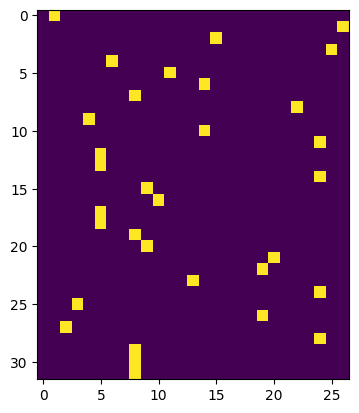

In [23]:
plt.imshow(F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]));

In [24]:
dlogits = dnorm_logits.clone()
dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes
cmp('logits', dlogits, logits)

logits          | exact: True  | approximate: True  | maxdiff: 0.0


In [25]:
dh = dlogits @ W2.T 
dW2 = h.T @ dlogits
db2 = dlogits.sum(0)

cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)

h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0


In [27]:
dhpreact = (1.0 - h**2) * dh
cmp('hpreact', dhpreact, hpreact)

hpreact         | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10


In [28]:
dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
dbnraw = bngain * dhpreact
dbnbias = dhpreact.sum(0, keepdim=True)

cmp('bngain', dbngain, bngain)
cmp('bnbias', dbnbias, bnbias)
cmp('bnraw', dbnraw, bnraw)

bngain          | exact: False | approximate: True  | maxdiff: 2.7939677238464355e-09
bnbias          | exact: False | approximate: True  | maxdiff: 3.725290298461914e-09
bnraw           | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10


In [30]:
dbndiff = bnvar_inv * dbnraw
dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv


cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bnvar', dbnvar, bnvar)


cmp('bndiff', dbndiff, bndiff)

bnvar_inv       | exact: False | approximate: True  | maxdiff: 5.587935447692871e-09
bnvar           | exact: False | approximate: True  | maxdiff: 1.1641532182693481e-09
bndiff          | exact: False | approximate: False | maxdiff: 0.0012138168094679713
